In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
file_path = 'train.csv'  
df = pd.read_csv(file_path)
df.columns

Index(['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct',
       'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed',
       'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR',
       'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot',
       'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st',
       'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating',
       'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations'],
      dtype='object')

# Make Hypothetical Train and Test CSVs

In [3]:
test_df = df[df['fs_year'] == 2012]
train_df = df[df['fs_year'] != 2012]

# test_df.to_csv('test_for_2012.csv', index=False)
# train_df.to_csv('train_for_2012.csv', index=False)

# Helper FUNCTIONS
-----
- calculate_default_within_year
- create growth features
- make_quantiles

In [4]:
def calculate_default_within_year(df, stmt_date_col='stmt_date', def_date_col='def_date', days_until_statement=150):
    """
    Calculate a default status within an adjusted timeframe and create a column indicating this in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing statement and default dates.
    - stmt_date_col (str): Column name for the statement date.
    - def_date_col (str): Column name for the default date.
    - days_until_statement (int): Number of days to add to the statement date before calculating the one-year window. Default is 150.
    
    Returns:
    - float: The mean of the 'default_within_timeframe' column, representing the proportion of defaults within the adjusted one-year period.
    """
    # Convert columns to datetime
    df[stmt_date_col] = pd.to_datetime(df[stmt_date_col])
    df[def_date_col] = pd.to_datetime(df[def_date_col])
    
    # Adjust the statement date by adding days_until_statement
    adjusted_stmt_date = df[stmt_date_col] + pd.DateOffset(days=days_until_statement)
    
    # Calculate one year after the adjusted statement date
    one_year_after = adjusted_stmt_date + pd.DateOffset(years=1)
    
    # Define default status within the adjusted one-year period and create the column
    df['default'] = ((df[def_date_col] >= adjusted_stmt_date) & (df[def_date_col] <= one_year_after)).astype(int)
    
    # Return the mean of the default_within_timeframe column
    return df

def make_quantiles(df, field, num_quantiles=4, custom_bins = {}, new_column_name=None, new=True, preproc_params = None):
    """
    Creates a new column in the DataFrame indicating the quantile for each row based on a specified field.
   
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - field (str): The column name of the field to compute quantiles for.
    - num_quantiles (int): The number of quantiles to divide the field into (default is 4 for quartiles).
    - new_column_name (str): The name for the new column to store the quantile information.
                             If None, defaults to '{field}_quantile'.
   
    Returns:
    - pd.DataFrame: The DataFrame with the new quantile column added.
    """
     # Set the new column name if not provided
    if new_column_name is None:
        new_column_name = f"{field}_quantile"
       
    if new:
        if new_column_name in custom_bins:
            print(f'Custom bins for {new_column_name}')
            bins = custom_bins[new_column_name]
            bins = [-np.inf]+bins[1:-1]+[np.inf]
           
            data_to_cut = df[field]#.replace([np.inf, -np.inf], [df[field][np.isfinite(df[field])].max(), df[field][np.isfinite(df[field])].min()])
            cut = pd.cut(data_to_cut, bins=bins, labels=False, duplicates = 'drop', include_lowest=True) + 1  # Adding 1 to make quantiles start from 1
        else:
           
            data_to_cut = df[field]#.replace([np.inf, -np.inf], [df[field][np.isfinite(df[field])].max(), df[field][np.isfinite(df[field])].min()])
            cut, bins = pd.qcut(data_to_cut, q=num_quantiles, labels=False, retbins=True, duplicates = 'drop')
            bins = [-np.inf]+bins.tolist()[1:-1]+[np.inf]

            cut = pd.cut(data_to_cut, bins=bins, labels=False, duplicates = 'drop', include_lowest=True) + 1  # Adding 1 to make quantiles start from 1
   
       
        # Calculate the quantiles and create the new column
        df[new_column_name] = cut
        prob_values = df.groupby(cut)[['default']].mean()
       
        df[f'{new_column_name}_values'] = cut.to_frame().merge(prob_values, on=field, how='left')['default'].fillna(0.01).values

        preproc_params['quantile_bins'][new_column_name] = bins
        preproc_params['quantile_values'][new_column_name] = prob_values
       
    else:
        print(new_column_name)
        bins = preproc_params['quantile_bins'][new_column_name]
        prob_values = preproc_params['quantile_values'][new_column_name]

        cut = pd.cut(df[field], bins=bins, labels=False, duplicates = 'drop', include_lowest=True) + 1  # Adding 1 to make quantiles start from 1
        # print(cut)
        # print(cut.to_frame())
        # print(prob_values)
        df[new_column_name] = cut
        df[f'{new_column_name}_values'] = cut.to_frame().merge(prob_values, on=field, how='left')['default'].fillna(0.01).values
       
    return df, preproc_params

# Test this

In [5]:
def calculate_conditional_pd_for_categorical(df, field, default_col='default', new=True, preproc_params=None):
    """
    Calculate the conditional probability of default for each unique category in a categorical field.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - field (str): The categorical column name for which to calculate conditional PD.
    - default_col (str): The column name for the default indicator (1 for default, 0 for non-default).
    
    Returns:
    - pd.DataFrame: The DataFrame with a new column for conditional PD values by category.
    """
    if new:
        # Create a new column name for storing default probabilities
        prob_column_name = f"{field}_pd"
        
        # Calculate the default probability for each unique category
        category_default_prob = df.groupby(field)[default_col].mean()
        
        # Map the default probability to each row based on its category
        df[prob_column_name] = df[field].map(category_default_prob)
        
        # Optionally store the probabilities in preproc_params if needed for later
        
        preproc_params['category_pd'][f'{field}_pd_values'] = category_default_prob
    else:
        print(f'using training pds for {field}')
        category_default_prob = preproc_params['category_pd'][f'{field}_pd_values']
        df[f'{field}_pd'] = df[field].map(category_default_prob).fillna(0.01)
    
    return df, preproc_params

In [6]:
def create_growth_features(df, id_col, date_col, field,  historical_df = None, new=True, ):
    """
    Creates a growth feature and its quantiles based on percentage change in the specified field,
    grouped by ID and sorted by date.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - id_col (str): The column name for the unique identifier (e.g., 'id').
    - date_col (str): The column name for the date to sort by (e.g., 'stmt_date').
    - field (str): The column name for which to calculate the growth feature.

    Returns:
    - pd.DataFrame: DataFrame with the growth feature and its quantiles added.
    """
    if new:
        df = df.sort_values(by=[id_col, date_col])
   
        # Calculate percentage change for the growth feature
        growth_feature = f"{field}_growth"
        df[growth_feature] = df.groupby(id_col)[field].pct_change()
       
        # Fill missing values (first occurrence per group) with 0
        df[growth_feature] = df[growth_feature].fillna(0)

        df['is_first_occurrence'] = (df[id_col] != df[id_col].shift()).astype(int).values
    else:
        # join historical and testing data frame
        # Sort by ID and date to calculate growth correctly
        concat_df = pd.concat([df, historical_df]).sort_values(by=[id_col, date_col])

        concat_df['is_first_occurrence'] = (concat_df[id_col] != concat_df[id_col].shift()).astype(int).values
       
        # Calculate percentage change for the growth feature
        growth_feature_name = f"{field}_growth"
        concat_df[growth_feature_name] = concat_df.groupby(id_col)[field].pct_change().values

        df = df.merge(concat_df[[growth_feature_name, id_col,date_col]], on=[id_col,date_col], how='left')
        
        if 'is_first_occurrence' not in df.columns:
            # df = df.join(concat_df[['is_first_occurrence']], how='left')
            df = df.merge(concat_df[['is_first_occurrence', id_col,date_col]], on=[id_col,date_col], how='left')

       
       
        # Fill missing values (first occurrence per group) with 0
        df[growth_feature_name] = df[growth_feature_name].fillna(0)
    return df

# Preprocess
----
Join Train and Test DFs, preprocess, split

In [7]:
def data_imputation(df):
    # Condition to check if EBITDA is missing or zero and prof_operations is not
    df['ebitda'] = np.where((df['ebitda'].isna() | (df['ebitda'] == 0)) & df['prof_operations'].notna() & (df['prof_operations'] != 0),
                            df['prof_operations'], df['ebitda'])

    # Condition to check if prof_operations is missing or zero and EBITDA is not
    df['prof_operations'] = np.where((df['prof_operations'].isna() | (df['prof_operations'] == 0)) & df['ebitda'].notna() & (df['ebitda'] != 0),
                                     df['ebitda'], df['prof_operations'])
    
    # if we have operating profit, and profit shows 0, set to operating profit instead
    df['profit'] = df.apply(lambda row: 1 if row['profit'] == 0 and row['prof_operations'] == 0
                            else row['prof_operations'] if row['profit'] == 0 and row['prof_operations'] != 0
                            else row['profit'], axis=1)
    #if all else fails, impute ebitda based on ratio of total assets
    df['ebitda'] = df['ebitda'].fillna(df['asst_tot'] * 0.05)
    df['cash_and_equiv'] = df['cash_and_equiv'].fillna(df['asst_tot'] * 0.05)
    df['profit'] = df['profit'].fillna(0.01)

    #do roe
    df['roe'] = df['profit'] / df['eqty_tot']
    df['roe'] = df['roe'].fillna(0)

    # Define if we have ebitda and operating rev is 0, set to ebitda
    df['rev_operating'] = df.apply(lambda row: 
                                 row['ebitda'] if row['rev_operating'] == 0 and row['ebitda'] > 0 
                                 else 1 if row['rev_operating'] == 0 and row['ebitda'] <= 0
                                 else row['rev_operating'], axis=1)
    df['rev_operating'] = df['rev_operating'].fillna(df['ebitda']).fillna(1)

    # Define if we have ebitda and operating rev is 0, set to ebitda
    df['rev_operating'] = df.apply(lambda row: 
                                 row['ebitda'] if row['rev_operating'] == 0 and row['ebitda'] > 0 
                                 else 1 if row['rev_operating'] == 0 and row['ebitda'] <= 0
                                 else row['rev_operating'], axis=1)
    df['rev_operating'] = df['rev_operating'].fillna(df['ebitda']).fillna(1)
    df['cf_operations'] = df['cf_operations'].fillna(df['rev_operating'])


    #make unique city id for 
    df['HQ_city'] = df['HQ_city'].fillna(1000.0)

    #set AR to 0 if not present
    df['AR'] = df['AR'].fillna(0)
    #set asst_tot to eqty_tot if not present, else set to 0
    df['asst_tot'] = np.where(df['asst_tot'].isna() | (df['asst_tot'] == 0), df['eqty_tot'], df['asst_tot'])
    df['asst_tot'] = df['asst_tot'].fillna(0)
    df['eqty_tot'] = df['eqty_tot'].fillna(0)
    #set debt_st or debt_lt to 0 if na
    df['liab_lt'] = df['liab_lt'].fillna(0)
    df['debt_st'] = df['debt_st'].fillna(0)
    df['debt_lt'] = df['debt_lt'].fillna(0)


    
    return df

In [8]:
def add_sector_group(df, sector_col='ateco_sector', new_col='sector_group'):
    """
    Adds a 'sector_group' column to the DataFrame based on grouped sector mappings for sector codes.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the sector codes.
    - sector_col (str): Column name for sector codes in the DataFrame (default is 'sector_code').
    - new_col (str): Column name for the new sector group mapping (default is 'sector_group').

    Returns:
    - pd.DataFrame: DataFrame with an additional 'sector_group' column.
    """
    # Define grouped sector mappings
    grouped_sectors = {
        'Construction and Real Estate': [41.0, 42.0, 43.0, 68.0, 71.0, 81.0],
        'Materials and Fabrication': [7.0, 8.0, 16.0, 17.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 37.0, 38.0, 39.0, 46.0],
        'Machinery and Equipment': [26.0, 27.0, 28.0, 31.0, 33.0, 52.0],
        'Automobiles and Transport': [29.0, 30.0, 45.0, 49.0, 50.0, 51.0, 53.0],
        'Consumer Products and Retail': [10.0, 11.0, 12.0, 13.0, 14.0, 47.0, 55.0, 56.0],
        'Technology, Media, and Telecommunications (TMT)': [58.0, 59.0, 60.0, 61.0, 62.0, 63.0],
        'Energy and Utilities': [5.0, 6.0, 35.0, 36.0],
        'Healthcare and Social Services': [21.0, 86.0, 87.0, 88.0],
        'Services and Professional Activities': [69.0, 70.0, 72.0, 73.0, 74.0, 77.0, 78.0, 79.0],
        'Mixed-Industry Sectors': [1.0, 2.0, 3.0, 90.0, 91.0, 92.0, 93.0, 94.0, 99.0]
    }
    
    # Reverse mapping from sector codes to group names
    sector_code_to_group = {code: group for group, codes in grouped_sectors.items() for code in codes}
    
    # Map the sector codes in the DataFrame to sector groups
    df[new_col] = df[sector_col].map(sector_code_to_group).fillna('Unknown')  # Assign 'Unknown' if no match found
    
    return df

In [9]:
def add_region_group(df, province_col='HQ_city', new_col='regional_code'):
    """
    Adds a 'regional_code' column to the DataFrame based on grouped region mappings for province codes.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the province codes.
    - province_col (str): Column name for province codes in the DataFrame.
    - new_col (str): Column name for the new region group mapping (default is 'regional_code').

    Returns:
    - pd.DataFrame: DataFrame with an additional 'regional_code' column.
    """
    # Define grouped region mappings
    grouped_regions = {
        '1': [1, 2, 3, 4, 5, 6, 96, 103],
        '2': [7],
        '3': [108, 98, 20, 19, 18, 17, 15, 16, 14, 13, 12, 97],
        '4': [21, 22],
        '5': [28, 29, 27, 26, 25, 24, 23],
        '6': [30, 25, 31, 32, 93],
        '7': [11, 10, 8, 9],
        '8': [39, 41, 99, 40, 38, 33, 36, 35, 34, 37],
        '9': [52, 100, 53, 50, 51, 48, 49, 47, 46, 45],
        '10': [54, 55],
        '11': [41, 42, 43, 44, 109],
        '12': [60, 58, 59, 56, 57],
        '13': [66, 67, 68, 69],
        '14': [70, 94],
        '15': [61, 62, 63, 64, 65],
        '16': [75, 110, 74, 71, 72, 73],
        '17': [76, 77],
        '18': [78, 79, 80, 101, 102],
        '19': [89, 88, 87, 86, 84, 83, 82, 81, 85],
        '20': [106, 104, 90, 91, 105, 92, 95, 107]
    }

    
    # Create a reverse mapping from province code to region code
    province_to_region_mapping = {province: region for region, provinces in grouped_regions.items() for province in provinces}
    
    # Map the province codes in the DataFrame to region codes
    df[new_col] = df[province_col].map(province_to_region_mapping).fillna('Unknown')  # Assign 'Unknown' if no match found
    
    return df


In [10]:
def pre_process(df, historical_df=None, custom_bins = None, new=True, preproc_params = None, quantiles = 10, days_until_statement = 150):
    """
    Preprocesses 

    Parameters:
    - df (pd.DataFrame): The input DataFrame 

    Returns:
    - pd.DataFrame: The DataFrame with new features and quantiles added.
    """
    # Impute missing values
    df = data_imputation(df)

    # Calculate default status within one year
    df = calculate_default_within_year(df, days_until_statement=days_until_statement)
    
    # Create quantiles for total assets
    df, preproc_params = make_quantiles(df, field='asst_tot', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate total liabilities and financial leverage ratio (assume debts are zero if left na)
    df['liab_tot'] = np.where(df['debt_st'].isna(), 0, df['debt_st'])  + np.where(df['debt_lt'].isna(), 0, df['debt_lt'])
    df['financial_leverage'] = df['liab_tot'] / df['asst_tot']
    df, preproc_params = make_quantiles(df, field='financial_leverage', custom_bins=custom_bins, num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate profitability ratio
    df['profitability_ratio'] = df['profit'] / df['asst_tot']
    df, preproc_params = make_quantiles(df, field='profitability_ratio', custom_bins=custom_bins, num_quantiles=quantiles, new=new, preproc_params=preproc_params)
    #doe roe too
    df, preproc_params = make_quantiles(df, field='roe', custom_bins=custom_bins, num_quantiles=quantiles, new=new, preproc_params=preproc_params)
    
    # Calculate net income growth by ID and sort by statement date
    df['net_income'] = df['profit']
    df = create_growth_features(df, historical_df = historical_df, id_col='id', date_col='stmt_date', field='net_income', new=new)
    df, preproc_params = make_quantiles(df, field='net_income_growth', custom_bins=custom_bins, num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate Quick Ratio Version 2
    df['quick_ratio_v2'] = np.where(df['debt_st'] == 0, 100, (df['cash_and_equiv'] + df['AR']) / df['debt_st'])
    #fill with median, mean is too high, skewed
    df['quick_ratio_v2'] = df['quick_ratio_v2'].fillna(df['asst_tot'] * 0.8)
    df, preproc_params = make_quantiles(df, field='quick_ratio_v2', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate sales growth by ID and sort by statement date
    df['sales'] = df['rev_operating']
    df = create_growth_features(df, historical_df = historical_df, id_col='id', date_col='stmt_date', field='sales', new=new)
    df, preproc_params = make_quantiles(df, field='sales_growth', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate cash-assets ratio
    df['cash_assets_ratio'] = df['cash_and_equiv'] / df['asst_tot']
    df, preproc_params = make_quantiles(df, field='cash_assets_ratio', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate Debt Service Coverage Ratio (DSCR) 
    # (roughly mean financing expense but not 0 for imputation)
    df['exp_financing'] = df['exp_financing'].replace(0, 10000)
    df['exp_financing'] = df['exp_financing'].fillna(10000)
    df['dscr'] = df['ebitda'] / df['exp_financing']
    df, preproc_params = make_quantiles(df, field='dscr', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    #handle sector data
    df = add_sector_group(df)
    df, preproc_params = calculate_conditional_pd_for_categorical(df, field='ateco_sector', default_col='default' ,new=new, preproc_params=preproc_params)
    df, preproc_params = calculate_conditional_pd_for_categorical(df, field='sector_group', default_col='default',new=new, preproc_params=preproc_params)
    
    #do cities
    df = add_region_group(df)
    df, preproc_params = calculate_conditional_pd_for_categorical(df, field='regional_code', default_col='default', new=new, preproc_params=preproc_params)

    #do cfo
    df['liab_st'] = df['liab_tot'] - df['liab_lt']
    df['cfo'] = df.apply(lambda row: 100 if row['liab_st'] == 0 else row['cf_operations'] / row['liab_st'], axis=1)
    df, preproc_params = make_quantiles(df, field='cfo', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    #do legal_struct
    df, preproc_params = calculate_conditional_pd_for_categorical(df, field='legal_struct', default_col='default',new=new,preproc_params=preproc_params)



    return df, preproc_params

In [11]:
def process_test(train_file, test_file, quantiles = 50, days_until_statement=150):
    """
    Reads in train and test CSVs, adds a train/test flag, concatenates, applies preprocessing, and returns only the test set.
    
    Parameters:
    - train_file (str): File path for the training CSV file.
    - test_file (str): File path for the test CSV file.
    - days_until_statement (int): Additional parameter for the preprocessing function, default is 150.
    
    Returns:
    - pd.DataFrame: The processed DataFrame containing only the rows from the test set.
    """
    # Read in the CSV files
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    
    test_df['stmt_date'] = pd.to_datetime(test_df['stmt_date'])
    test_df['def_date'] = pd.to_datetime(test_df['def_date'], format="%d/%m/%Y")
    test_df.sort_values('stmt_date', inplace=True)
    
    train_df['stmt_date'] = pd.to_datetime(train_df['stmt_date'])
    train_df['def_date'] = pd.to_datetime(train_df['def_date'], format="%d/%m/%Y")
    train_df.sort_values('stmt_date', inplace=True)
    
    # Add flag columns to indicate train and test rows
    train_df['train_test_flag'] = 'train'
    test_df['train_test_flag'] = 'test'

    with open('quantile_custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {},
        'category_pd':{}
    }
    
    processed_train, preproc_params = pre_process(train_df, custom_bins=custom_bins, preproc_params = preproc_params,  quantiles = quantiles, days_until_statement = days_until_statement)
    
    # Concatenate the DataFrames
    # combined_df = pd.concat([train_df, test_df], ignore_index=True)
    
    
    # Run the preprocessing function on the combined DataFrame
    processed_test, preproc_params = pre_process(test_df, historical_df=processed_train, new=False, preproc_params = preproc_params,  quantiles = quantiles, days_until_statement = days_until_statement)
        
    return processed_test, processed_train, preproc_params

In [12]:
def plot_feature_default_probabilities(df, features):
    """
    Plots bar charts for the conditional probability of default for each specified feature with a corresponding '_pd' column,
    and includes the count of rows in each category.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the feature columns and their corresponding '_pd' columns.
    - features (list): List of feature names to plot (assumes each feature has a corresponding '_pd' column in the DataFrame).
    """
    for feature in features:
        pd_column = f'{feature}_pd'
        
        # Ensure both the feature and its corresponding '_pd' column exist
        if feature in df.columns and pd_column in df.columns:
            # Calculate mean default probability and count of rows for each category in the feature
            category_summary = df.groupby(feature).agg(
                default_prob=(pd_column, 'mean'),
                count=(pd_column, 'size')
            ).sort_values('default_prob')

            # Create labels with counts for the bars
            labels = [f"{round(prob * 100, 2)}% ({count})" for prob, count in zip(category_summary['default_prob'], category_summary['count'])]

            # Plotting the default probabilities for the current feature
            plt.figure(figsize=(10, 6))
            bars = plt.bar(category_summary.index, category_summary['default_prob'], color='skyblue')
            plt.title(f'Conditional Probability of Default by {feature}')
            plt.xlabel(feature)
            plt.ylabel('Default Probability')

            # Add text annotations with default probability and count
            for bar, label in zip(bars, labels):
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label, ha='center', va='bottom', fontsize=9)

            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Either '{feature}' or '{pd_column}' is missing in the DataFrame.")


In [13]:
# Function to plot quantile vs quantile values for each feature
def plot_quantile_vs_quantile_values(df):
    """
    Plot quantile values for each feature if both the quantile and corresponding
    quantile values columns are available, based on column name pattern.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    """
    # Identify columns with the pattern '_quantile' and '_quantile_values'
    quantile_columns = [col for col in df.columns if col.endswith('_quantile')]
    quantile_values_columns = [col for col in df.columns if col.endswith('_quantile_values')]

    # Loop over each quantile column and check if the corresponding quantile values column exists
    for quantile_col in quantile_columns:
        feature_name = quantile_col.replace('_quantile', '')
        quantile_values_col = f"{feature_name}_quantile_values"

        # Plot if both columns exist
        if quantile_col in df.columns and quantile_values_col in df.columns:
            plt.figure(figsize=(10, 6))
            sns.lineplot(x=df[quantile_col], y=df[quantile_values_col], marker='o', label=f'{feature_name}')
            plt.title(f'Quantile vs Quantile Values for {feature_name}')
            plt.xlabel(f'{feature_name} Quantiles')
            plt.ylabel(f'{feature_name} Quantile Values')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"Could not find both columns for feature '{feature_name}'.")


# RUN OVER TRAIN AND TEST DATA TO PREP TEST DATA

In [14]:
test_processed, train_processed, _ = process_test('train_for_2012.csv', 'test_for_2012.csv')

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for roe_quantile
Custom bins for net_income_growth_quantile
asst_tot_quantile
financial_leverage_quantile
profitability_ratio_quantile
roe_quantile
net_income_growth_quantile
quick_ratio_v2_quantile
sales_growth_quantile
cash_assets_ratio_quantile
dscr_quantile
using training pds for ateco_sector
using training pds for sector_group
using training pds for regional_code
cfo_quantile
using training pds for legal_struct


In [15]:
(train_processed[train_processed.columns[train_processed.columns.str.contains('growth')]]==0).sum()

net_income_growth                    225293
net_income_growth_quantile                0
net_income_growth_quantile_values         0
sales_growth                         238424
sales_growth_quantile                     0
sales_growth_quantile_values              0
dtype: int64

In [16]:
test_processed[train_processed.columns[train_processed.columns.str.contains('growth')]].isna().sum()

net_income_growth                    0
net_income_growth_quantile           0
net_income_growth_quantile_values    0
sales_growth                         0
sales_growth_quantile                0
sales_growth_quantile_values         0
dtype: int64

In [17]:
test_processed[(test_processed['net_income_growth'].isna())&(test_processed['is_first_occurrence']==1)][['id','stmt_date','sales','net_income','net_income_growth','sales_growth']]

,id,stmt_date,sales,net_income,net_income_growth,sales_growth


In [18]:
test_processed.describe()

,Unnamed: 0,id,stmt_date,HQ_city,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,asst_fixed_fin,...,dscr_quantile,dscr_quantile_values,ateco_sector_pd,sector_group_pd,regional_code_pd,liab_st,cfo,cfo_quantile,cfo_quantile_values,legal_struct_pd
count,185639.0000,185639.0000,185639,185639.0000,185639.0000,2138,185639.0000,185639.0000,185639.0000,185639.0000,...,185639.0000,185639.0000,185639.0000,185639.0000,185639.0000,185639.0000,185639.0000,185639.0000,185639.0000,185639.0000
mean,2022616.9884,3806341984.5445,2012-12-31 00:00:00,41.3667,46.2376,2013-08-11 23:21:36.538821376,2012.0000,468956.7494,3498057.8183,1186071.4156,...,25.0804,0.0146,0.0134,0.0135,0.0135,6623641.4236,0.3476,25.1422,0.0146,0.0137
min,21.0000,520288.0000,2012-12-31 00:00:00,1.0000,1.0000,2013-01-01 00:00:00,2012.0000,-2554740.0000,-516457.0000,-1312106.0000,...,1.0000,0.0039,0.0000,0.0066,0.0052,-2212876000.0000,-5529.2109,1.0000,0.0024,0.0000
25%,756585.5000,1393210528.5000,2012-12-31 00:00:00,16.0000,32.0000,2013-05-23 06:00:00,2012.0000,0.0000,65055.5000,0.0000,...,11.0000,0.0048,0.0087,0.0113,0.0119,1345797.0000,0.0000,12.0000,0.0041,0.0131
50%,1917891.0000,2447580420.0000,2012-12-31 00:00:00,36.0000,46.0000,2013-08-08 00:00:00,2012.0000,7540.0000,647328.0000,1744.0000,...,25.0000,0.0075,0.0138,0.0143,0.0139,2216232.0000,0.0317,25.0000,0.0079,0.0131
75%,3184621.5000,4363860505.0000,2012-12-31 00:00:00,58.0000,68.0000,2013-11-19 00:00:00,2012.0000,78245.5000,2186559.5000,81402.5000,...,38.0000,0.0137,0.0157,0.0153,0.0143,4416961.5000,0.1004,38.0000,0.0143,0.0131
max,4885789.0000,98111220178.0000,2012-12-31 00:00:00,1000.0000,99.0000,2013-12-31 00:00:00,2012.0000,3708467000.0000,36083657000.0000,5518101000.0000,...,50.0000,0.0695,0.0588,0.0199,0.0512,13291796000.0000,14901.0000,50.0000,0.0926,0.0195
std,1383502.9079,6893541254.0265,NaN,30.0640,19.7691,NaN,0.0000,15822724.2186,102328222.5880,26134911.6771,...,14.9296,0.0163,0.0047,0.0026,0.0023,78348318.4962,40.7441,14.8890,0.0201,0.0027


In [19]:
train_processed.describe()

,Unnamed: 0,id,stmt_date,HQ_city,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,asst_fixed_fin,...,dscr_quantile,dscr_quantile_values,ateco_sector_pd,sector_group_pd,regional_code_pd,liab_st,cfo,cfo_quantile,cfo_quantile_values,legal_struct_pd
count,837913.0000,837913.0000,837913,837913.0000,837913.0000,53286,837913.0000,837751.0000,837810.0000,837676.0000,...,837913.0000,837913.0000,837913.0000,837913.0000,837913.0000,837913.0000,837913.0000,837913.0000,837913.0000,837913.0000
mean,2085602.0997,3676827466.4686,2010-02-09 23:02:28.693718528,41.6008,45.9828,2012-01-19 19:43:13.086364416,2009.1127,468282.4226,3391800.8767,1168513.8648,...,25.5000,0.0136,0.0136,0.0136,0.0136,6433239.9836,0.1832,25.5000,0.0136,0.0136
min,17.0000,520288.0000,2007-12-31 00:00:00,1.0000,1.0000,2008-01-01 00:00:00,2007.0000,-3442959.0000,-1711468.0000,-2490262.0000,...,1.0000,0.0039,0.0000,0.0066,0.0052,-17345889000.0000,-32312.8125,1.0000,0.0024,0.0000
25%,717213.0000,1304150897.0000,2008-12-31 00:00:00,16.0000,31.0000,2011-02-07 00:00:00,2008.0000,330.0000,66924.2500,0.0000,...,13.0000,0.0048,0.0087,0.0113,0.0119,1411668.0000,0.0019,13.0000,0.0041,0.0131
50%,1929573.0000,2324600135.0000,2009-12-31 00:00:00,36.0000,46.0000,2012-02-16 00:00:00,2009.0000,8052.0000,585117.5000,1303.0000,...,25.0000,0.0072,0.0138,0.0143,0.0139,2266362.0000,0.0328,25.0000,0.0076,0.0131
75%,3331272.0000,4139590964.0000,2010-12-31 00:00:00,58.0000,68.0000,2013-02-01 00:00:00,2010.0000,74551.5000,2039478.7500,70000.0000,...,38.0000,0.0133,0.0157,0.0153,0.0143,4500098.0000,0.0979,38.0000,0.0140,0.0131
max,4885817.0000,98120940170.0000,2011-12-31 00:00:00,1000.0000,99.0000,2013-12-31 00:00:00,2011.0000,3629878000.0000,58221437000.0000,8529187000.0000,...,50.0000,0.0695,0.0588,0.0199,0.0512,14874298000.0000,34459.0000,50.0000,0.0926,0.0195
std,1476063.5483,6939805025.1824,NaN,32.6961,19.6667,NaN,1.4010,14649100.7413,134621011.1571,29302925.5121,...,14.4309,0.0153,0.0047,0.0025,0.0024,68576701.5528,80.9594,14.4309,0.0187,0.0027


In [20]:
test_processed.columns

Index(['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct',
       'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed',
       'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR',
       'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot',
       'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st',
       'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating',
       'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations',
       'train_test_flag', 'default', 'asst_tot_quantile',
       'asst_tot_quantile_values', 'liab_tot', 'financial_leverage',
       'financial_leverage_quantile', 'financial_leverage_quantile_values',
       'profitability_ratio', 'profitability_ratio_quantile',
       'profitability_ratio_quantile_values', 'roe_quantile',
       'roe_quant

In [21]:
features = [
    'asst_tot', 'asst_tot_quantile_values',
    'roe', 'roe_quantile_values',
    'financial_leverage', 'financial_leverage_quantile_values',
    'profitability_ratio', 'profitability_ratio_quantile_values',
    'net_income_growth', 'net_income_growth_quantile_values',
    'quick_ratio_v2', 'quick_ratio_v2_quantile_values',
    'sales_growth', 'sales_growth_quantile_values',
    'cash_assets_ratio', 'cash_assets_ratio_quantile_values',
    'cfo', 'cfo_quantile_values',
    'dscr', 'dscr_quantile_values', 
    'ebitda','is_first_occurrence',
    'ateco_sector_pd', 'sector_group_pd',
    'regional_code', 'regional_code_pd'
]

In [22]:
# Check for missing values
missing_values = test_processed[features].isnull().sum()
print('missing vals:')
print((missing_values[missing_values > 0]).sort_values(ascending=False))

missing vals:
Series([], dtype: int64)


In [23]:
# Check for missing values
missing_values = train_processed[features].isnull().sum()
print('missing vals:')
print((missing_values[missing_values > 0]).sort_values(ascending=False))

missing vals:
Series([], dtype: int64)


In [24]:
# all_processed.to_csv('../data/processed.csv')

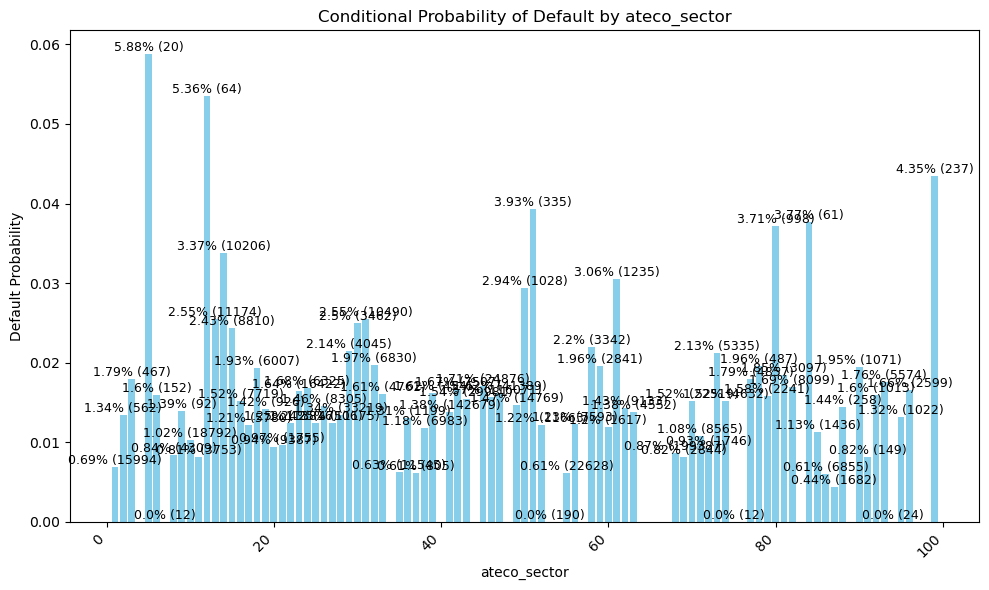

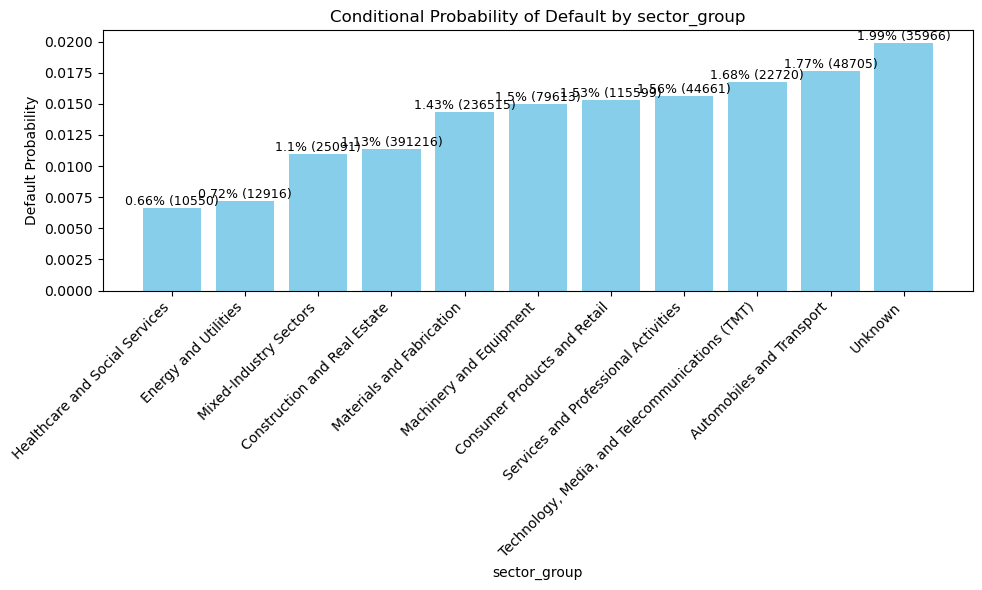

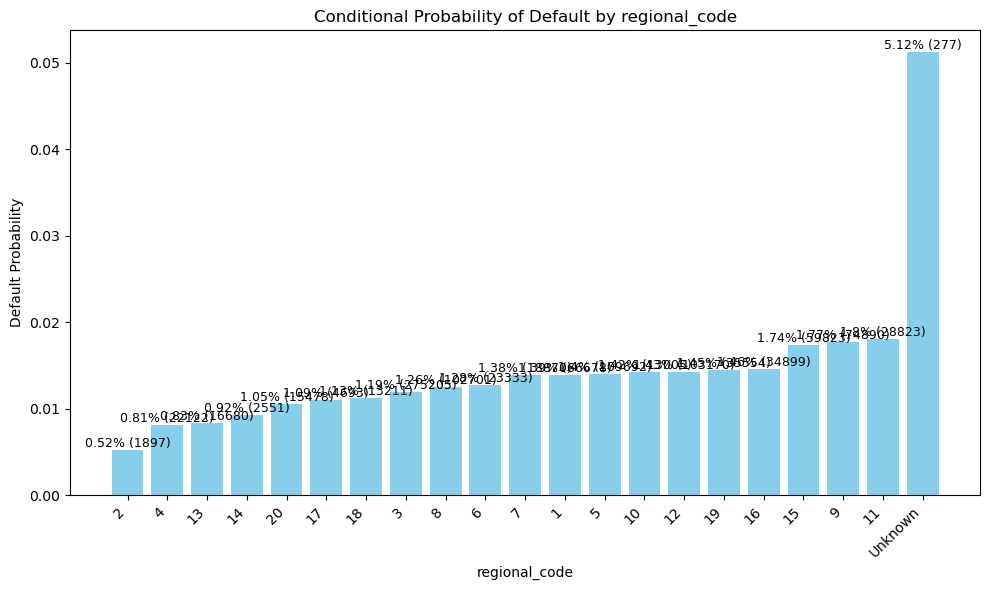

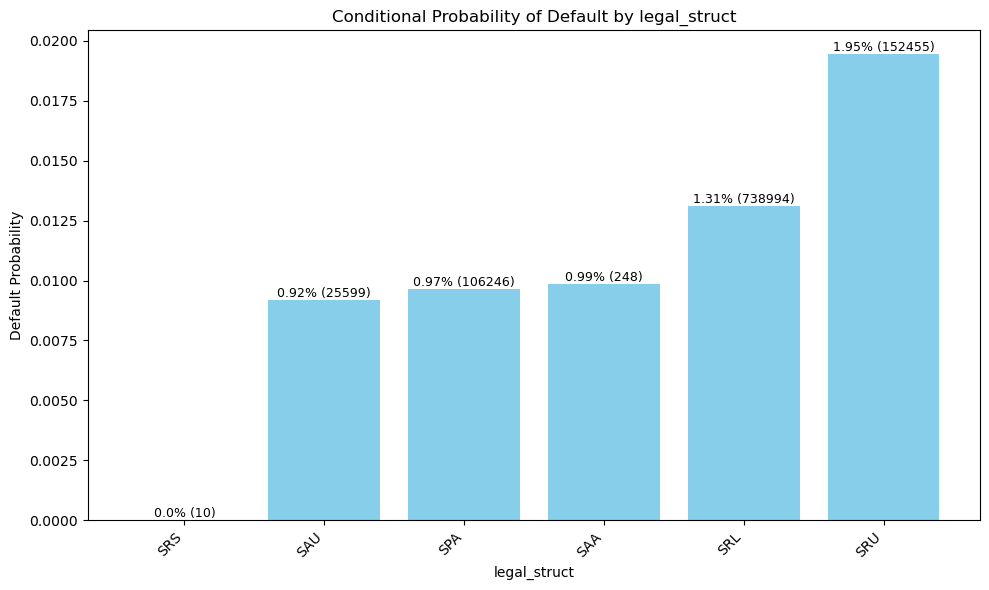

In [25]:
features = ['ateco_sector', 'sector_group','regional_code', 'legal_struct']
all_processed = pd.concat([train_processed, test_processed], ignore_index=True)
# Plot the default probabilities for each specified feature
plot_feature_default_probabilities(all_processed, features)

In [26]:
all_processed[~all_processed['net_income_growth'].isna()][['net_income_growth','sales_growth','is_first_occurrence']]

,net_income_growth,sales_growth,is_first_occurrence
0,0.0000,0.0000,1
1,-3.9233,-0.5261,0
2,-0.2753,-0.3398,0
3,0.0742,-0.1160,0
4,-0.0276,-0.0470,0
...,...,...,...
1023547,0.0220,0.3303,0
1023548,-0.2813,0.0061,0
1023549,-0.9532,0.3203,0
1023550,0.0000,0.0000,1


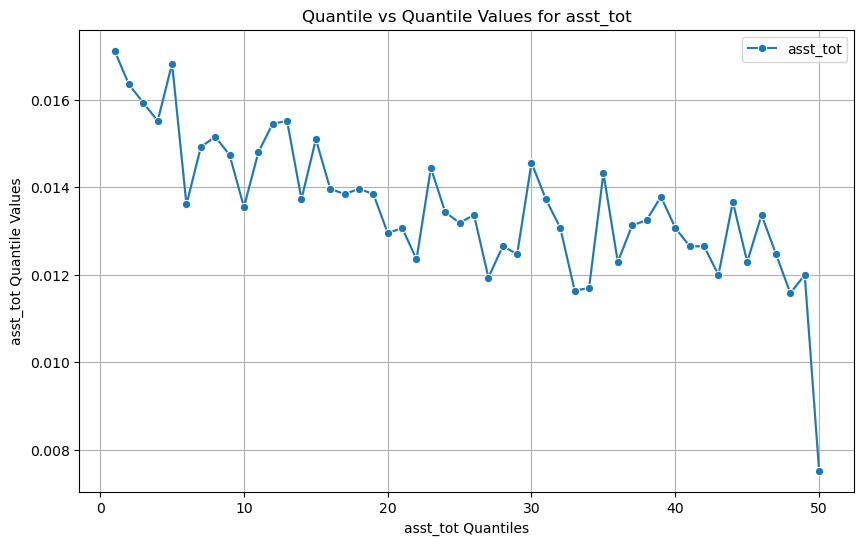

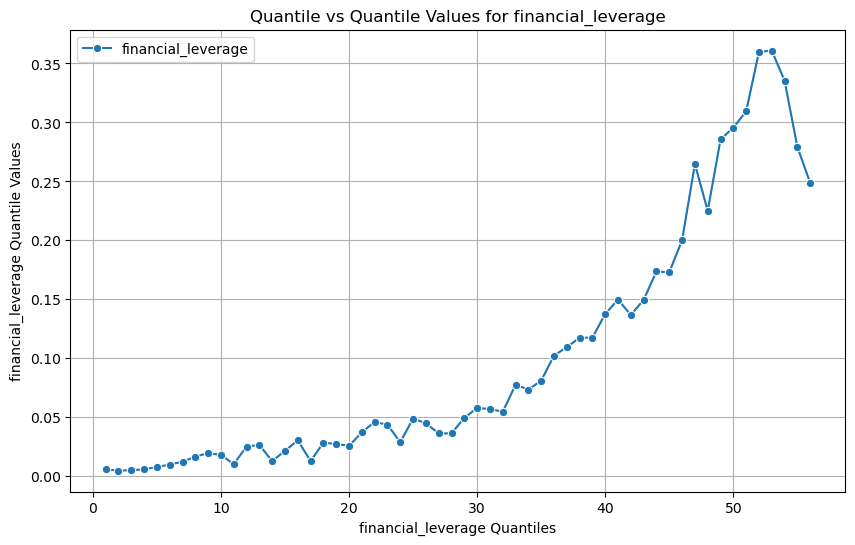

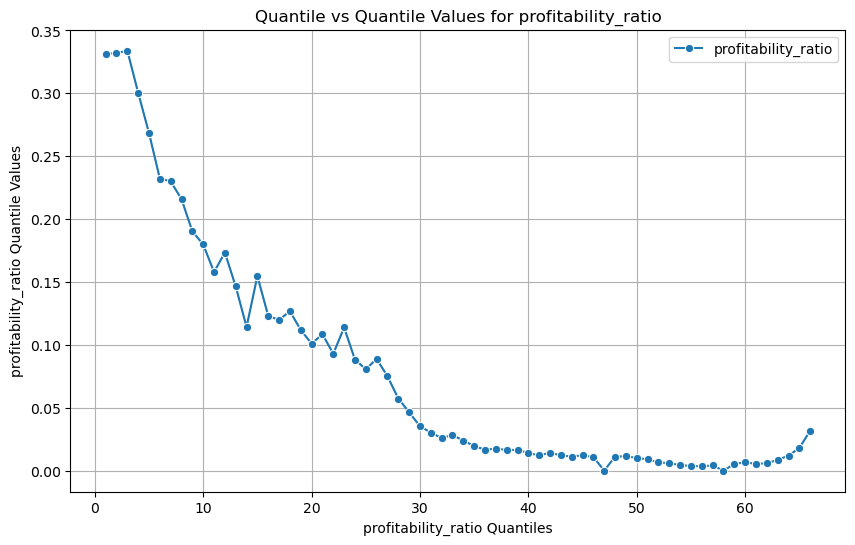

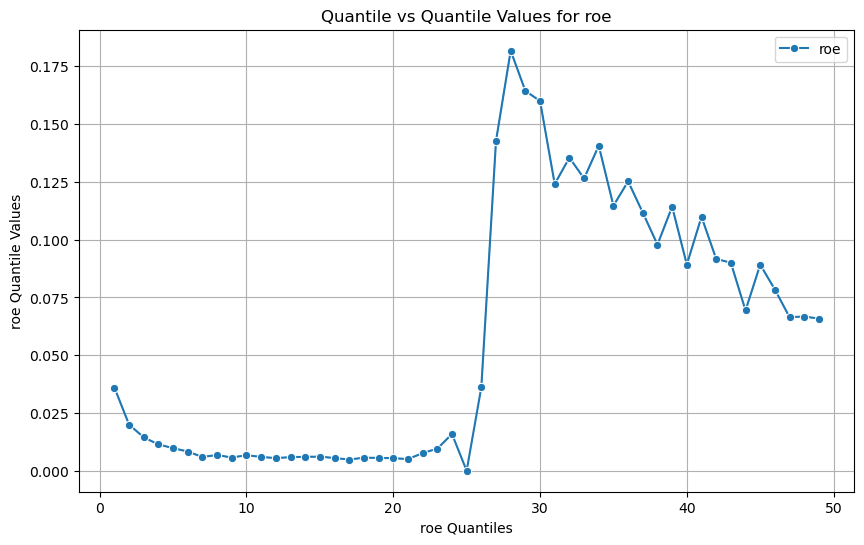

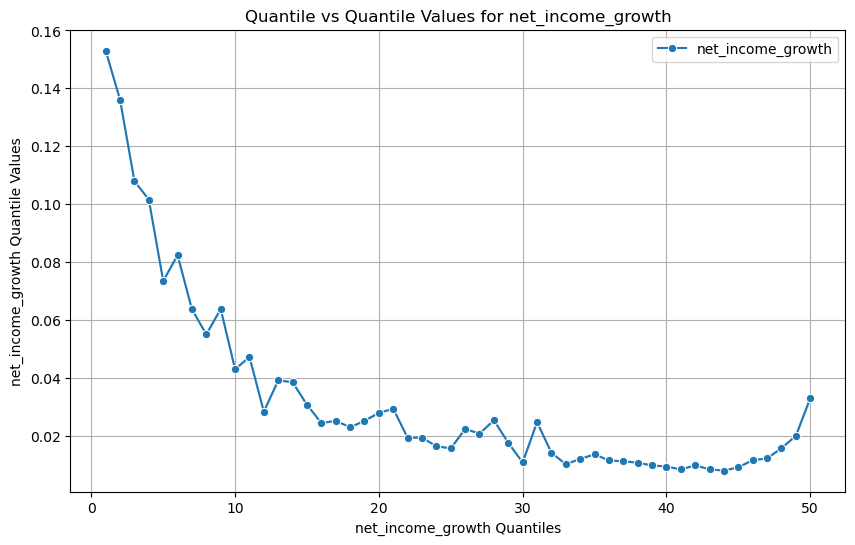

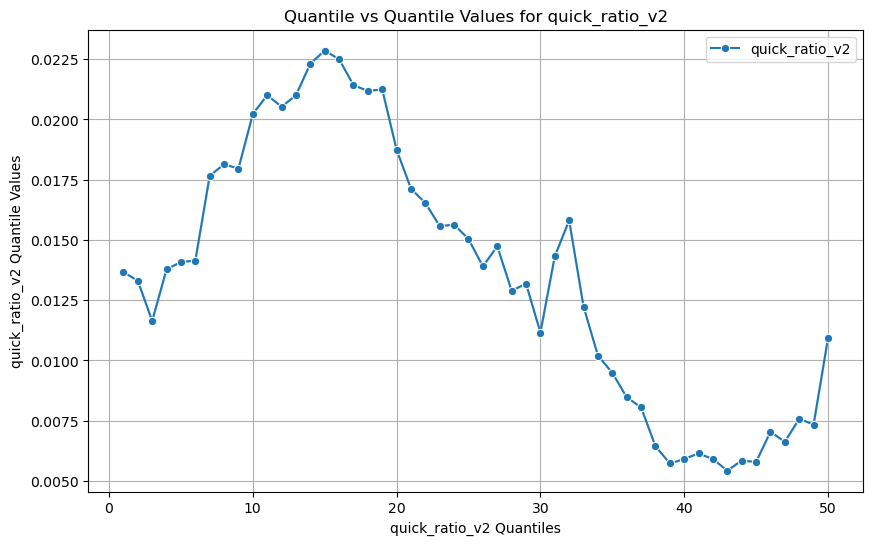

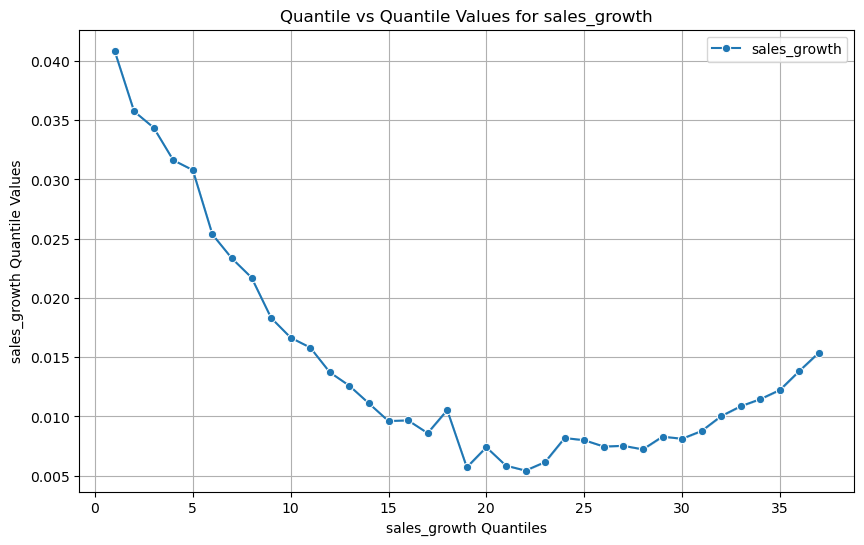

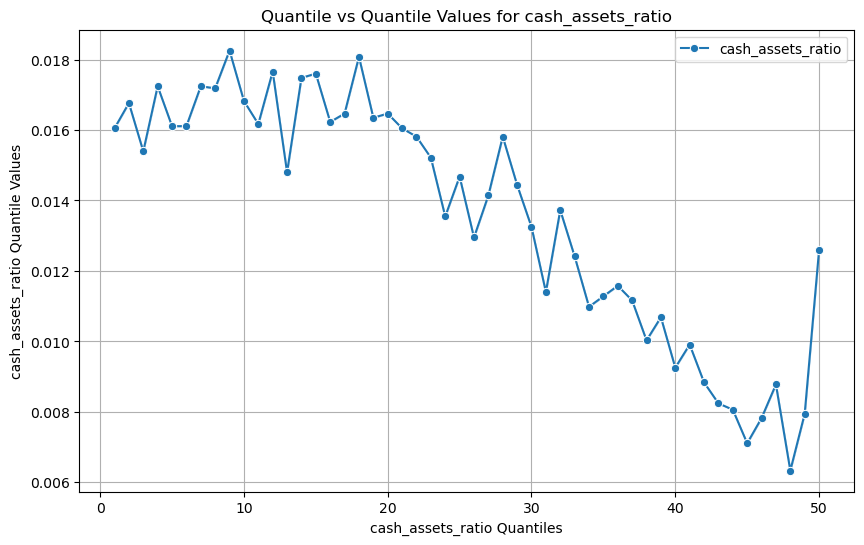

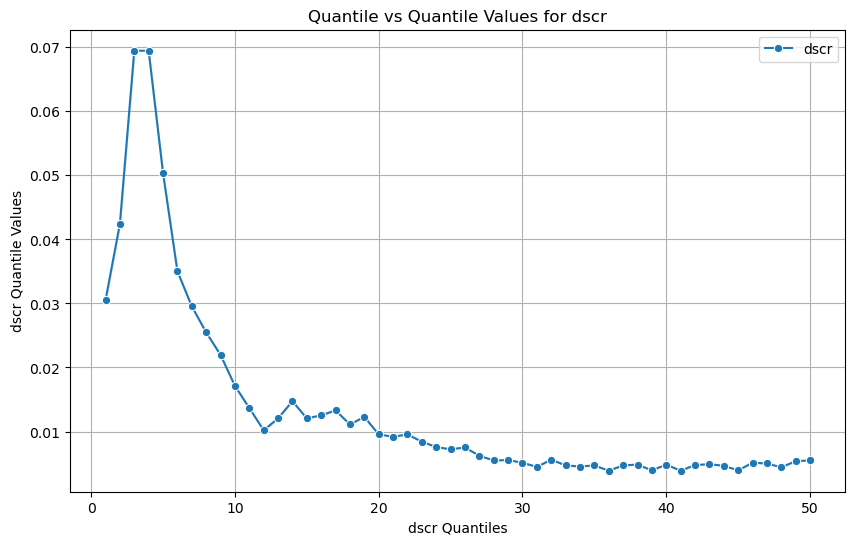

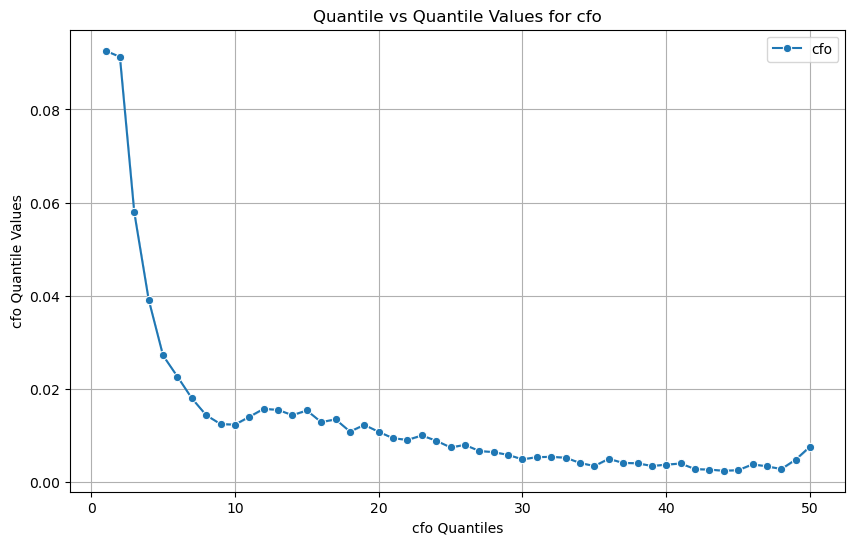

In [27]:
plot_quantile_vs_quantile_values(all_processed)

In [28]:
# Check for missing values
missing_values = all_processed.isnull().sum()
print('missing vals:')
print((missing_values[missing_values > 0]).sort_values(ascending=False))

missing vals:
eqty_corp_family_tot    1023552
def_date                 968128
days_rec                 740211
debt_fin_st              122772
debt_bank_st             121331
AP_st                    120635
AP_lt                     92244
debt_fin_lt               92068
debt_bank_lt              90971
margin_fin                40758
prof_financing              656
inc_extraord                305
asst_fixed_fin              237
liab_lt_emp                 162
asst_intang_fixed           162
asst_tang_fixed             103
taxes                        32
roa                          27
inc_financing                26
COGS                         24
prof_operations              21
goodwill                     21
wc_net                        6
asst_current                  1
dtype: int64


In [29]:
# test_processed.to_csv('test_processed_data_for_2012.csv', index=False)
# train_processed.to_csv('train_processed_data_for_2012.csv', index=False)

In [30]:
all_processed[all_processed['cfo'].isna()][['liab_tot','liab_lt','liab_st','cf_operations','cfo']]

,liab_tot,liab_lt,liab_st,cf_operations,cfo
